In [1]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from model import Unet_model
from Modules import STFT
from data import my_dataset, collate_fn
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from model import DownSample, UpSample

class Unet_model(nn.Module):
    def __init__(
        self, input_channel=1, out_channel=32, complex_input=True, log_flag=False, subband_flag=True):
        super().__init__()
        self.complex_input = complex_input
        self.log_flag = log_flag
        self.subband_flag = subband_flag
        
        self.down_1 = DownSample(
                input_channel=40,
                out_channel=64, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(64)
            )
        
        self.down_2 = DownSample(
                input_channel=64,
                out_channel=128, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(128)
            )
        
        self.lstm = nn.LSTM(input_size=256, 
                            hidden_size=256, 
                            num_layers=1, 
                            batch_first=True)
        
        
        self.up_1 = UpSample(
            input_channel=128+128, 
            out_channel=64, 
            kernel_size=(6, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(64)
        )    
        

        self.up_2 = UpSample(
            input_channel=64+64, 
            out_channel=32, 
            kernel_size=(4, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(32)
        )   
        
        
        self.fc = nn.Sequential(
            nn.Linear(40*32, 200),
            #nn.Sigmoid()
        )
    
    def cac2cws(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c,k,f//k,t)
        x = x.reshape(b,c*k,f//k,t)
        return x
    
    def cws2cac(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c//k,k,f,t)
        x = x.reshape(b,c//k,f*k,t)
        return x
    
    def forward(self, x):
        B, C, F, T = x.shape
        
        if self.complex_input:
            x = torch.concat([x.real, x.imag], dim=1)
        elif self.log_flag:
            x = torch.log(x + 1e-5)
        
        if self.subband_flag:
            x = self.cac2cws(x)
        
        x1 = self.down_1(x)
        x2 = self.down_2(x1)        
        _, C_c, F_c, _ = x2.shape
        x = x2.view(B, -1, T).permute(0, 2, 1) # (B, C, F, T) -> (B, C*F, T) -> (B, T, C*F)
        
        x = self.lstm(x)[0] + x
        
        x = x.permute(0, 2, 1).view(B, C_c, F_c, T)
        x = self.up_1(torch.concat([x, x2],dim=1))
        x = self.up_2(torch.concat([x, x1],dim=1))
        
        x = x.view(B, -1, T).permute(0, 2, 1)
        x = self.fc(x)
        
        return x.view(B, 1, F, T)

In [3]:
def plot_magn(magn, title):
    plt.title(title)
    plt.imshow(torch.log(magn+ 1e-5).detach(), cmap="viridis", origin="lower", aspect="auto")
    plt.show();
    
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

In [4]:
data_train = my_dataset('./beam_data/train')
data_valid = my_dataset('./beam_data/valid')

In [5]:
train_target = data_train[2][0]
train_sample = data_train[2][1]

In [6]:
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

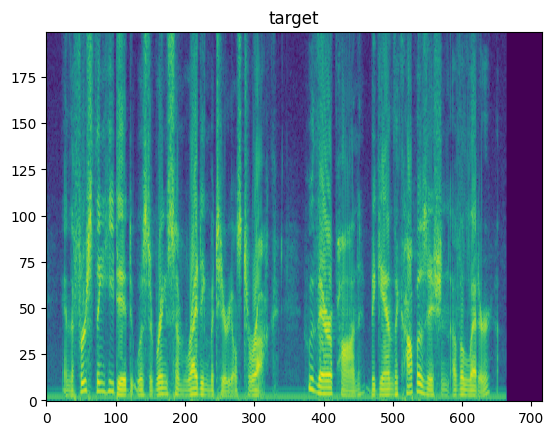

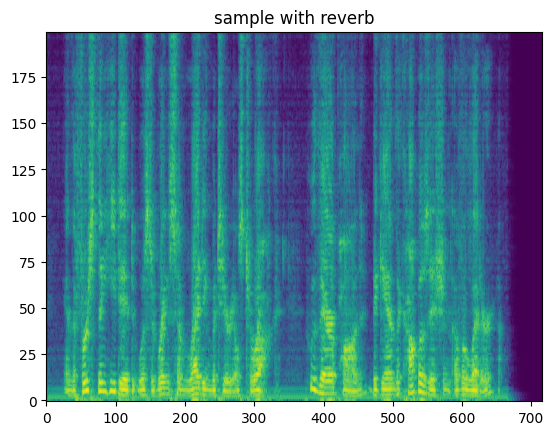

In [7]:
plot_magn(stft.stft(train_target).abs()[0], 'target')
plot_magn(stft.stft(train_sample).abs()[0], 'sample with reverb')

# train

In [8]:
from tqdm import tqdm
from torchmetrics import ScaleInvariantSignalDistortionRatio

In [9]:
from torch.utils.data import DataLoader
from loss import MultiResSpecLoss

In [10]:
# init

train_dataloader = DataLoader(data_train, batch_size=1, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(data_valid, batch_size=1, collate_fn=collate_fn, shuffle=False)

unet_mask = Unet_model()
si = ScaleInvariantSignalDistortionRatio()
losses_epoch_train = []
metrics_epoch_train = []
losses_epoch_valid = []
metrics_epoch_valid = []
lrs = []
epochs = 100
criterion = nn.MSELoss()#MultiResSpecLoss(n_ffts=[1024, 400],f_complex=100, factor=100, gamma=0.3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optim = torch.optim.Adam(unet_mask.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=50
        )
unet_mask.to(device);

In [11]:
import logging
import logging.config

LOGGER = logging.getLogger("Train")
LOGGER.setLevel(logging.DEBUG)
file_handler = logging.FileHandler("reverb.log")
file_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(message)s")
file_handler.setFormatter(formatter)
LOGGER.addHandler(file_handler)
LOGGER.info(f"epchs, train_loss, train_metric, valid_loss, valid_metric")

In [12]:
import torch as th

def pipline(model, sample):
    spec_sample = stft.stft(sample)
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)
    mask = model(spec_sample)
    mag_predict = mag * mask
    
    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, sample.shape[-1])
    return wave_predict

In [ ]:
mn = -100
for epoch in tqdm(range(epochs)):
    losses_train = []
    metrics_train = []
    unet_mask.train()
    for batch_idx, batch in enumerate(train_dataloader):
        optim.zero_grad()
        target, noise, sample = batch
        predictions = pipline(unet_mask, sample.to(device))
        
        loss = 0.7*criterion(predictions, target.to(device)) + 0.3*F.mse_loss(predictions, target.to(device))
        loss.backward()
        optim.step()
        
        metrics_train.append(si(predictions.detach().cpu(), target.cpu()[0]))
        losses_train.append(loss.item())
    
    losses_epoch_train.append(sum(losses_train)/len(losses_train))
    metrics_epoch_train.append(sum(metrics_train)/len(metrics_train))
    
    losses_val = []
    metrics_val = []
    unet_mask.eval()    
    for batch_idx, batch in enumerate(test_dataloader):
        target, noise, sample = batch
        predictions = pipline(unet_mask, sample.to(device))
        
        loss = 0.7*criterion(predictions, target.to(device)) + 0.3*F.mse_loss(predictions, target.to(device))
        
        metrics_val.append(si(predictions.detach().cpu(), target.cpu()[0]))
        losses_val.append(loss.item())
        
    losses_epoch_valid.append(sum(losses_val)/len(losses_val))
    metrics_epoch_valid.append(sum(metrics_val)/len(metrics_val))
    
    lrs.append(scheduler.get_lr()[0])
    scheduler.step()
    # print("Epoch [{}/{}], train_loss: {:.4f}, train_metric: {:.4f}, valid_loss: {:.4f}, valid_metric: {:.4f}".format(epoch+1, epochs, 
    #                                                                                                                  losses_epoch_train[-1], 
    #                                                                                                                  metrics_epoch_train[-1], 
    #                                                                                                                  losses_epoch_valid[-1], 
    #                                                                                                                  metrics_epoch_valid[-1]))
    
    LOGGER.info(f"{epoch+1},{losses_epoch_train[-1]},{metrics_epoch_train[-1]},{losses_epoch_valid[-1]},{metrics_epoch_valid[-1]}")
    if mn < metrics_epoch_valid[-1]:
        mn = metrics_epoch_valid[-1]
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': unet_mask.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses_epoch_train[-1],
            }, f'checkpoint_reverb.pt')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]